 ## Wrangle and Analyze Twitter Data
 
 Goal: wrangle WeRateDogs Twitter data to create interesting and trustworthy analyses and visualizations. 
 
 The Twitter archive contains very basic tweet information. Additional gathering, then assessing and cleaning is required for analyses and visualizations.

Three datasets:

- Twitter_archive_enhanced.csv
- Image_predictions.tsv
    - using the Requests library and the following URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv
- Get tweet retweet count, and ‘like’ count from Twitter API, tweet_json.txt
    - Using Tweepy library, https://www.tweepy.org/ 


**Project Steps Overview**

Step 1: Gather Data

Step 2: Assessing data

Step 3: Cleaning data

Step 4: Storing data

Step 5: Analyzing, and visualizing data

Step 6: Reporting
- data wrangling efforts
- data analyses and visualizations



**Assumptions:**


- Retrievers are the most popular dog breed
- Puppers best the best rated dogs
- iphones are the most use source

Packages

In [120]:
# load necessary libraries
import pandas as pd
import requests
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import tweepy
import json
%run config


<h3><span style="color:orange">Gather Data</span></h3>

**CSV File** - archieved Tweets

In [121]:
# get csv data, first look at data
df1=pd.read_csv('twitter-archive-enhanced.csv')
df1.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
959,751251247299190784,NaN,NaN,2016-07-08 03:07:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Gilbert. He's being chased by a battal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/751251247...,10,10,Gilbert,None,None,None,None
334,832682457690300417,NaN,NaN,2017-02-17 20:05:43 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Prosperous good boy 13/10 socioeconomic af htt...,NaN,NaN,NaN,https://twitter.com/telegraph/status/832268302...,13,10,None,None,None,None,None
1765,678410210315247616,NaN,NaN,2015-12-20 03:02:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Jerome. He can shoot french fries...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/678410210...,10,10,Jerome,None,None,None,None
543,805958939288408065,NaN,NaN,2016-12-06 02:15:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Penny. She fought a bee...,7.827226e+17,4.196984e+09,2016-10-02 23:23:04 +0000,https://twitter.com/dog_rates/status/782722598...,10,10,Penny,None,None,None,None
658,791672322847637504,NaN,NaN,2016-10-27 16:06:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When she says you're a good boy and you know y...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/791672322...,13,10,None,None,None,None,None


**TSV File** - image predictions file

In [122]:
# get image predictions data, first look
try:
    url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
    df2=pd.read_csv(url, sep='\t')
except:
    print("A problem occured with your link")

In [123]:
# write to tsv file
response=requests.get(url)
open('image_predictions.tsv', 'wb').write(response.content)

335079

In [124]:
df2.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
937,703611486317502464,https://pbs.twimg.com/media/CcO66OjXEAASXmH.jpg,1,Pembroke,0.756441,True,basenji,0.126621,True,Cardigan,0.080117,True
1826,835264098648616962,https://pbs.twimg.com/media/C5d0QtvXMAI_7uz.jpg,2,hyena,0.736871,False,Chesapeake_Bay_retriever,0.087503,True,meerkat,0.042058,False
1914,854120357044912130,https://pbs.twimg.com/media/C9px7jyVwAAnmwN.jpg,4,black-and-tan_coonhound,0.854861,True,Doberman,0.050792,True,bluetick,0.021762,True
894,699434518667751424,https://pbs.twimg.com/media/CbTj--1XEAIZjc_.jpg,1,golden_retriever,0.836572,True,kuvasz,0.105946,True,Labrador_retriever,0.025144,True
950,704859558691414016,https://pbs.twimg.com/media/CcgqBNVW8AE76lv.jpg,1,pug,0.284428,True,teddy,0.156339,False,mitten,0.138915,False


**Twitter Data** - Twitter API tweets data

In [125]:
# Create an API object
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

Get Twitter API data

In [126]:
# Fetch tweets from the twitter API using a loop
tweets = []
# list of Tweet Ids not found
ids_with_no_tweets = []

for tweet_id in df1['tweet_id']:   
    try:
        tweets.append(api.get_status(tweet_id, tweet_mode='extended'))
    except:
        ids_with_no_tweets.append(tweet_id)

Rate limit reached. Sleeping for: 735
Rate limit reached. Sleeping for: 1
Rate limit reached. Sleeping for: 739


Store Twitter API data

In [127]:
# Create a list of dictionaries
list_of_dicts = []
for each_json_tweet in tweets:
    list_of_dicts.append(each_json_tweet._json)
    
#Write list of dictionaries into a txt file
with open('tweets.txt', 'w') as f:
        f.write(json.dumps(list_of_dicts, indent=4))

In [128]:
# Dictionary to Dataframe
df3=pd.read_json('tweets.txt')

In [129]:
df3.sample(10)

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
210,2017-04-05 17:00:34+00:00,849668094696017920,849668094696017920,RT @dog_rates: This is Gidget. She's a spy pup...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,NaN,NaN,en,{'created_at': 'Sun Feb 19 01:23:00 +0000 2017...,NaN,NaN,NaN,NaN
2155,2015-11-24 02:54:30+00:00,668986018524233728,668986018524233728,This is Ruby. She's a Bimmington Fettuccini. O...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 668986015319760896, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
419,2017-01-13 21:04:55+00:00,820013781606658049,820013781606658048,RT @dog_rates: This is Oliver. He has dreams o...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,NaN,NaN,en,{'created_at': 'Fri Jan 13 17:00:21 +0000 2017...,NaN,NaN,NaN,NaN
1929,2015-12-06 18:56:46+00:00,673576835670777856,673576835670777856,Sun burnt dog here. Quite large. Wants to prom...,False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 673576829651841024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
888,2016-07-23 23:42:53+00:00,756998049151549440,756998049151549440,This is Oliver. He's an English Creamschnitzel...,False,"[0, 102]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 756998020437278720, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
1588,2016-01-07 18:41:01+00:00,685169283572338688,685169283572338688,Meet Gerbald. He just found out he's adopted. ...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 685169266828685312, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
1313,2016-03-02 00:05:17+00:00,704819833553219584,704819833553219584,This is Chesterson. He's a Bolivian Scoop Dog....,False,"[0, 137]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 704819829430218752, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
1997,2015-12-02 02:13:48+00:00,671874878652489728,671874878652489728,This is Mia. She was specifically told not get...,False,"[0, 132]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 671874870762934272, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
1087,2016-05-17 14:57:41+00:00,732585889486888962,732585889486888960,"When your teacher agreed on 10,000 RTs and no ...",False,"[0, 96]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 732585876857835521, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
1561,2016-01-11 18:39:05+00:00,686618349602762752,686618349602762752,This is Olivia. She just saw an adult wearing ...,False,"[0, 130]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 686618344242442241, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN


In [130]:
# Get desired data, check dataframe
#df3=df3[['created_at', 'id', 'favorited', 'retweeted']]
#df3.sample(5)

<h3><span style="color:orange"><em>Assess Data</em></span></h3>

Detect and document at least eight (8) quality issues and two (2) tidiness issues.

The following issues must be assessed.

- Only original ratings (no retweets) that have images. 
    - There are 5000+ tweets in the dataset 
    - Not all are dog ratings and some are retweets
- Assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
- The rating numerators are greater than the denominators does not need to be cleaned. 
    - This unique rating system is a big part of the popularity of WeRateDogs.
- Do not gather the tweets beyond August 1st, 2017. 


<h5><span style="color:#214AF6"><em>CSV file - archieved tweets</em></span></h5>

Visual assessment

In [131]:
df1.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [132]:
df1.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


In [133]:
df1.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
729,781955203444699136,NaN,NaN,2016-09-30 20:33:43 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Chipson. He weighed in at .3 ounces an...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/781955203...,11,10,Chipson,None,None,None,None
1695,681261549936340994,NaN,NaN,2015-12-27 23:53:05 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Panda. He's a Quackadilly Shooste...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/681261549...,9,10,Panda,None,None,None,None
1014,747204161125646336,NaN,NaN,2016-06-26 23:05:29 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Clark. He's deadly af. Clearly part sh...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/747204161...,10,10,Clark,None,None,None,None
502,813081950185472002,NaN,NaN,2016-12-25 18:00:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Baron. He's officially festive as h*ck...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/813081950...,11,10,Baron,None,None,None,None
2279,667405339315146752,NaN,NaN,2015-11-19 18:13:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Biden. Biden just tripped... 7/10 http...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667405339...,7,10,Biden,None,None,None,None


Programmatic assessment

In [134]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [135]:
df1[df1.duplicated()==True]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [136]:
df1.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


**df1( archieved tweets) Column Quality Issues**
- in_reply_to_status missing records
- in_reply_to_user_id missing records
- retweeted_status_id missing records
- retweeted_status_user_id missing records
- retweeted_status_timestamp missing records
- retweets duplicates
- expanded_urls missing records
- source hrf=, html used with url
- timestamp string not date
- extract source out of html code in source column

**df1( archieved tweets) Column Tidyness Issues**
- missing column for rating: numerator/denominator
- some numerators/denominators are huge
- zero denominator

<h5><span style="color:#214AF6"><em>TSV file - image predictions</em></span></h5>

Visual assessment

In [137]:
# check enties for a tweet id
df2[df2['tweet_id']==889531135344209921]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2060,889531135344209921,https://pbs.twimg.com/media/DFg_2PVW0AEHN3p.jpg,1,golden_retriever,0.953442,True,Labrador_retriever,0.013834,True,redbone,0.007958,True


In [138]:
# view top of df
df2.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [139]:
# view end of df
df2.tail()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


In [140]:
# get random sample
df2.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1437,773985732834758656,https://pbs.twimg.com/media/Cr2_6R8WAAAUMtc.jpg,4,giant_panda,0.451149,False,fur_coat,0.148001,False,pug,0.109570,True
584,678969228704284672,https://pbs.twimg.com/media/CWwu6OLUkAEo3gq.jpg,1,Labrador_retriever,0.680251,True,Chesapeake_Bay_retriever,0.201697,True,golden_retriever,0.019676,True
504,675888385639251968,https://pbs.twimg.com/media/CWE85snWIAEG5ES.jpg,1,West_Highland_white_terrier,0.672117,True,Old_English_sheepdog,0.146147,True,komondor,0.023141,True
1791,830583320585068544,https://pbs.twimg.com/media/C4bTH6nWMAAX_bJ.jpg,1,Labrador_retriever,0.908703,True,seat_belt,0.057091,False,pug,0.011933,True
1869,844580511645339650,https://pbs.twimg.com/media/C7iNfq1W0AAcbsR.jpg,1,washer,0.903064,False,dishwasher,0.032489,False,printer,0.016456,False


Programmatic assessment

In [141]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [142]:
df2[df2.duplicated()==True]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


df2(image prediction) Column Quality Issues
- p1 data naming convention inconsistent
- p2 data naming convention inconsistent
- p3 data naming convention inconsistent

<h5><span style="color:#214AF6"><em>JSON file - twitter API</em></span></h5>

Visual Assessment

In [143]:
df3.head()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
0,2017-08-01 16:23:56+00:00,892420643555336193,892420643555336192,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
1,2017-08-01 00:17:27+00:00,892177421306343426,892177421306343424,This is Tilly. She's just checking pup on you....,False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2,2017-07-31 00:18:03+00:00,891815181378084864,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,False,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
3,2017-07-30 15:58:51+00:00,891689557279858688,891689557279858688,This is Darla. She commenced a snooze mid meal...,False,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
4,2017-07-29 16:00:24+00:00,891327558926688256,891327558926688256,This is Franklin. He would like you to stop ca...,False,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN


In [144]:
df3.tail()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
2321,2015-11-16 00:24:50+00:00,666049248165822465,666049248165822464,Here we have a 1949 1st generation vulpix. Enj...,False,"[0, 120]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666049244999131136, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2322,2015-11-16 00:04:52+00:00,666044226329800704,666044226329800704,This is a purebred Piers Morgan. Loves to Netf...,False,"[0, 137]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666044217047650304, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2323,2015-11-15 23:21:54+00:00,666033412701032449,666033412701032448,Here is a very happy pup. Big fan of well-main...,False,"[0, 130]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666033409081393153, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2324,2015-11-15 23:05:30+00:00,666029285002620928,666029285002620928,This is a western brown Mitsubishi terrier. Up...,False,"[0, 139]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666029276303482880, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2325,2015-11-15 22:32:08+00:00,666020888022790149,666020888022790144,Here we have a Japanese Irish Setter. Lost eye...,False,"[0, 131]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666020881337073664, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN


In [145]:
df3.sample(5)

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
1754,2015-12-18 01:31:14+00:00,677662372920729601,677662372920729600,In honor of the new Star Wars movie. Here's Yo...,False,"[0, 108]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 677662334756761600, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
1650,2015-12-30 02:54:35+00:00,682032003584274432,682032003584274432,This is Ulysses. He likes holding hands and hi...,False,"[0, 93]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 682031998756470785, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
1653,2015-12-29 17:36:07+00:00,681891461017812993,681891461017812992,Say hello to Charlie. He's scholarly af. Quite...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 681891446547427328, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
1895,2015-12-08 03:09:46+00:00,674063288070742018,674063288070742016,This is Earl. Earl is lost. Someone help Earl....,False,"[0, 135]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 674063277207457792, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2166,2015-11-23 18:02:38+00:00,668852170888998912,668852170888998912,Say hello to Bobb. Bobb is a Golden High Fescu...,False,"[0, 144]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 668852165096677376, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN


Programmatic assessment

In [146]:
# programmatic assessment
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2326 entries, 0 to 2325
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   created_at                     2326 non-null   datetime64[ns, UTC]
 1   id                             2326 non-null   int64              
 2   id_str                         2326 non-null   int64              
 3   full_text                      2326 non-null   object             
 4   truncated                      2326 non-null   bool               
 5   display_text_range             2326 non-null   object             
 6   entities                       2326 non-null   object             
 7   extended_entities              2056 non-null   object             
 8   source                         2326 non-null   object             
 9   in_reply_to_status_id          77 non-null     float64            
 10  in_reply_to_status_id_st

**df3( API tweet data) column Quality Issues**
- Many unwanted columns
    - Desired columns: ['created_at', 'id', 'favorit_count', 'retweet_count']

<h2><span style="color:orange"><em>Cleaning Data</em></span></h2>

Clean all of the issues documented while assessing. 


- Make a copy of each piece of data.

- Use the define-code-test framework and clearly document it.

- Cleaning includes merging individual pieces of data according to the rules of tidy data. 

- The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

<h5><span style="color:#214AF6"><em>CSV file - archieved tweets</em></span></h5>

**df1( archieved tweets) Column Quality Issues**
- in_reply_to_status missing records
- in_reply_to_user_id missing records
- retweeted_status_id missing records
- retweeted_status_user_id missing records
- retweeted_status_timestamp missing records
- expanded_urls missing records, messy values
- source hrf=, html used with url
    - extract source out of html code in 'source' column
- timestamp string not date
- duplicate, retweets


**df1( archieved tweets) Column Tidyness Issues**
- missing column for rating: numerator/denominator
- dog lingo columns make nan, melt before analysis, [dog lingo](#dog-lingo)

In [147]:
# Make a copy
df1_clean=df1.copy()

In [148]:
df1_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

**Define**

Drop the retweets, reply records

**CODE**

In [149]:
# drop in_reply_to_status_id, retweeted_status_id with entries
df1_clean=df1_clean[df1_clean['in_reply_to_status_id'].isnull()]
df1_clean = df1_clean[df1_clean['retweeted_status_id'].isnull()]


**TEST**

In [150]:
df1_clean['in_reply_to_status_id'].unique()

array([nan])

In [151]:
df1_clean['retweeted_status_id'].unique()

array([nan])

In [152]:
df1_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2097 non-null   int64  
 1   in_reply_to_status_id       0 non-null      float64
 2   in_reply_to_user_id         0 non-null      float64
 3   timestamp                   2097 non-null   object 
 4   source                      2097 non-null   object 
 5   text                        2097 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2094 non-null   object 
 10  rating_numerator            2097 non-null   int64  
 11  rating_denominator          2097 non-null   int64  
 12  name                        2097 non-null   object 
 13  doggo                       2097 

**DEFINE**

- delete unwanted data for analysis
    - in_reply_to_status missing records
    - in_reply_to_user_id missing records
    - retweeted_status_id missing records
    - retweeted_status_user_id missing records
    - retweeted_status_timestamp missing records

**CODE**

In [153]:
# drop columns
df1_clean=df1_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1)

**TEST**

In [154]:
df1_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2097 non-null   int64 
 1   timestamp           2097 non-null   object
 2   source              2097 non-null   object
 3   text                2097 non-null   object
 4   expanded_urls       2094 non-null   object
 5   rating_numerator    2097 non-null   int64 
 6   rating_denominator  2097 non-null   int64 
 7   name                2097 non-null   object
 8   doggo               2097 non-null   object
 9   floofer             2097 non-null   object
 10  pupper              2097 non-null   object
 11  puppo               2097 non-null   object
dtypes: int64(3), object(9)
memory usage: 213.0+ KB


**DEFINE**

- fix rows with missing data
    - expanded_urls missing records

The 'expanded_urls' column is a link to dog pictures posted per tweet id. If there is no expanded_url, there was no picture posted. 

We Rate Dogs rates dogs by picture so the rows with missing photos will be dropped.

In [155]:
df1_clean['expanded_urls'][0]

'https://twitter.com/dog_rates/status/892420643555336193/photo/1'

In [156]:
df1_clean['expanded_urls'][209]

'https://twitter.com/dog_rates/status/852226086759018497/video/1'

**CODE**

In [157]:
# view column info
df1_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2097 non-null   int64 
 1   timestamp           2097 non-null   object
 2   source              2097 non-null   object
 3   text                2097 non-null   object
 4   expanded_urls       2094 non-null   object
 5   rating_numerator    2097 non-null   int64 
 6   rating_denominator  2097 non-null   int64 
 7   name                2097 non-null   object
 8   doggo               2097 non-null   object
 9   floofer             2097 non-null   object
 10  pupper              2097 non-null   object
 11  puppo               2097 non-null   object
dtypes: int64(3), object(9)
memory usage: 277.5+ KB


In [158]:
# save tweet_id that will be dropped for later confirmation of no photo
no_photo=(df1_clean[df1_clean['expanded_urls'].isnull()].tweet_id).to_list()

In [159]:
df1_clean=df1_clean.dropna()

**TEST**

In [160]:
# checking they were dropped
df1_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2094 non-null   int64 
 1   timestamp           2094 non-null   object
 2   source              2094 non-null   object
 3   text                2094 non-null   object
 4   expanded_urls       2094 non-null   object
 5   rating_numerator    2094 non-null   int64 
 6   rating_denominator  2094 non-null   int64 
 7   name                2094 non-null   object
 8   doggo               2094 non-null   object
 9   floofer             2094 non-null   object
 10  pupper              2094 non-null   object
 11  puppo               2094 non-null   object
dtypes: int64(3), object(9)
memory usage: 212.7+ KB


In [161]:
df1_clean.sample(3)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1862,675432746517426176,2015-12-11 21:51:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy Friday. Here's some golden puppers. 12/1...,https://twitter.com/dog_rates/status/675432746...,12,10,None,None,None,None,None
23,887473957103951883,2017-07-19 00:47:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Canela. She attempted some fancy porch...,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
1615,685268753634967552,2016-01-08 01:16:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Hubertson. He's a Carmel Haberdashery....,https://twitter.com/dog_rates/status/685268753...,10,10,Hubertson,None,None,pupper,None


**DEFINE**

- source hrf=, html used with url
    - extract source out of html code in 'source' column

In [162]:
# view the unique source types
df1_clean['source'].unique()

array(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
       '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'],
      dtype=object)

**SOURCE**

1 - tweetdeck

2 - vine.co

3 - twitter.com

4 - iphone

In [163]:
# find and replace source categories with
numeric_var = {'source': {'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>':4, '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>':3, '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>':2, '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>':1}}
df1_clean = df1_clean.replace(numeric_var)

**TEST**

In [164]:
df1_clean.sample(3)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
220,850019790995546112,2017-04-06 16:18:05 +0000,4,Say hello to Boomer. He's a sandy pupper. Havi...,https://twitter.com/dog_rates/status/850019790...,12,10,Boomer,None,None,pupper,None
2082,670815497391357952,2015-11-29 04:04:12 +0000,4,This is Sage. He likes to burn shit. 10/10 htt...,https://twitter.com/dog_rates/status/670815497...,10,10,Sage,None,None,None,None
2032,671763349865160704,2015-12-01 18:50:38 +0000,4,Say hello to Mark. He's a good dog. Always rea...,https://twitter.com/dog_rates/status/671763349...,9,10,Mark,None,None,None,None


**DEFINE**

- timestamp string not date
    - convert timestamp from str to datetime

In [165]:
df1_clean['timestamp'][2]

'2017-07-31 00:18:03 +0000'

**CODE**

In [166]:
# change timestamp to datetime
df1_clean['timestamp']=pd.to_datetime(df1_clean['timestamp'])

**TEST**

In [167]:
df1_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2094 non-null   int64              
 1   timestamp           2094 non-null   datetime64[ns, UTC]
 2   source              2094 non-null   int64              
 3   text                2094 non-null   object             
 4   expanded_urls       2094 non-null   object             
 5   rating_numerator    2094 non-null   int64              
 6   rating_denominator  2094 non-null   int64              
 7   name                2094 non-null   object             
 8   doggo               2094 non-null   object             
 9   floofer             2094 non-null   object             
 10  pupper              2094 non-null   object             
 11  puppo               2094 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(4

In [168]:
df1_clean['timestamp'][4]

Timestamp('2017-07-29 16:00:24+0000', tz='UTC')

**DEFINE**

- missing column for rating: numerator/denominator
    - check for extreme values
    - check for zero denominators, change to 10

In [169]:
# chack numerator values
df1_clean[['rating_numerator', 'rating_denominator']]

,rating_numerator,rating_denominator
0,13,10
1,13,10
2,12,10
3,13,10
4,12,10
...,...,...
2351,5,10
2352,6,10
2353,9,10
2354,7,10


In [170]:
# check denominator values
df1_clean['rating_denominator'].value_counts()

10     2077
50        3
11        2
80        2
70        1
7         1
150       1
170       1
20        1
90        1
40        1
110       1
120       1
2         1
Name: rating_denominator, dtype: int64

As stated in WeRateDogs: 'WeRateDogs asks people to send photos of their dogs, then tweets selected photos rating and a humorous comment. Dogs are rated on a scale of one to ten, but are invariably given ratings in excess of the maximum, such as "13/10"'

The denominator should be 10. Without knowing Twitter user's intentions on the rating denominator and since most denominators are 10, I will drop all denominators not 10.

**CODE**

In [171]:
# keep only rows with rating_denominator is 10
df1_clean=df1_clean.loc[df1_clean['rating_denominator']==10]

**TEST**

In [172]:
# get all unique values of denominator rating
df1_clean['rating_denominator'].unique()

array([10], dtype=int64)

In [173]:
# create a rating column, rating_numerator/rating_denominator
df1_clean['rating']=df1_clean['rating_numerator']/df1_clean['rating_denominator']

In [174]:
df1_clean.sample(3)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,rating
2208,668625577880875008,2015-11-23 03:02:14+00:00,4,This is Maks. Maks just noticed something wasn...,https://twitter.com/dog_rates/status/668625577...,10,10,Maks,None,None,None,None,1.0
807,771908950375665664,2016-09-03 03:13:29+00:00,4,Doggo will persevere. 13/10\nhttps://t.co/yOVz...,https://twitter.com/yahoonews/status/771905568...,13,10,None,doggo,None,None,None,1.3
1527,690360449368465409,2016-01-22 02:28:52+00:00,4,Stop sending in lobsters. This is the final wa...,https://twitter.com/dog_rates/status/690360449...,9,10,the,None,None,None,None,0.9


In [175]:
# check for duplicated ids
df1_clean[df1_clean['tweet_id'].duplicated()]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,rating


In [176]:
# replace none with nan
df1_clean.replace('None', np.nan, inplace=True)

In [177]:
df1_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2077 entries, 0 to 2355
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2077 non-null   int64              
 1   timestamp           2077 non-null   datetime64[ns, UTC]
 2   source              2077 non-null   int64              
 3   text                2077 non-null   object             
 4   expanded_urls       2077 non-null   object             
 5   rating_numerator    2077 non-null   int64              
 6   rating_denominator  2077 non-null   int64              
 7   name                1488 non-null   object             
 8   doggo               83 non-null     object             
 9   floofer             10 non-null     object             
 10  pupper              229 non-null    object             
 11  puppo               24 non-null     object             
 12  rating              2077 non-null 

In [178]:
df1_clean.sample(3)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,rating
1232,713175907180089344,2016-03-25 01:29:21+00:00,4,Say hello to Opie and Clarkus. Clarkus fell as...,https://twitter.com/dog_rates/status/713175907...,10,10,Opie,NaN,NaN,NaN,NaN,1.0
2031,671768281401958400,2015-12-01 19:10:13+00:00,4,When you try to recreate the scene from Lady &...,https://twitter.com/dog_rates/status/671768281...,10,10,NaN,NaN,NaN,NaN,NaN,1.0
1621,684926975086034944,2016-01-07 02:38:10+00:00,4,Meet Bruiser &amp; Charlie. They are the best ...,https://twitter.com/dog_rates/status/684926975...,11,10,Bruiser,NaN,NaN,NaN,NaN,1.1


<h5><span style="color:#214AF6"><em>TSV file - image predictions</em></span></h5>

df2(image prediction) Column Quality Issues
- p1 data naming convention inconsistent
- p2 data naming convention inconsistent
- p3 data naming convention inconsistent

In [179]:
# Make a copy
df2_clean=df2.copy()

**DEFINE**

p1, p2, p3 naming conventions are inconsistant. Change all letters to lowercase.

In [180]:
# check df2_clean
df2_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [181]:
# check sample
df2_clean.sample(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1162,734912297295085568,https://pbs.twimg.com/media/CjLuzPvUoAAbU5k.jpg,1,Maltese_dog,0.847292,True,feather_boa,0.059379,False,Old_English_sheepdog,0.052758,True
1560,793271401113350145,https://pbs.twimg.com/media/CwJEIKTWYAAvL-T.jpg,1,Siberian_husky,0.231695,True,Eskimo_dog,0.206749,True,Pembroke,0.070120,True
125,668248472370458624,https://pbs.twimg.com/media/CUYYcMfXAAAixe7.jpg,1,Chihuahua,0.734547,True,miniature_pinscher,0.068294,True,toy_terrier,0.046367,True


**CODE**

In [182]:
# change string to lowercase
df2_clean['p1']= df2_clean['p1'].str.lower()
df2_clean['p2']= df2_clean['p2'].str.lower()
df2_clean['p3']= df2_clean['p3'].str.lower()

**TEST**

Check lower case

In [183]:
# check  lower case
df2_clean['p1'].unique()

array(['welsh_springer_spaniel', 'redbone', 'german_shepherd',
       'rhodesian_ridgeback', 'miniature_pinscher',
       'bernese_mountain_dog', 'box_turtle', 'chow', 'shopping_cart',
       'miniature_poodle', 'golden_retriever', 'gordon_setter',
       'walker_hound', 'pug', 'bloodhound', 'lhasa', 'english_setter',
       'hen', 'desktop_computer', 'italian_greyhound', 'maltese_dog',
       'three-toed_sloth', 'ox', 'malamute', 'guinea_pig',
       'soft-coated_wheaten_terrier', 'chihuahua',
       'black-and-tan_coonhound', 'coho', 'toy_terrier',
       'blenheim_spaniel', 'pembroke', 'llama',
       'chesapeake_bay_retriever', 'curly-coated_retriever', 'dalmatian',
       'ibizan_hound', 'border_collie', 'labrador_retriever', 'seat_belt',
       'snail', 'miniature_schnauzer', 'airedale', 'triceratops', 'swab',
       'hay', 'hyena', 'jigsaw_puzzle', 'west_highland_white_terrier',
       'toy_poodle', 'giant_schnauzer', 'vizsla', 'vacuum', 'rottweiler',
       'siberian_husky', 't

In [184]:
df2_clean['p2'].unique()

array(['collie', 'miniature_pinscher', 'malinois', 'redbone',
       'rottweiler', 'english_springer', 'mud_turtle', 'tibetan_mastiff',
       'shopping_basket', 'komondor', 'yorkshire_terrier',
       'english_foxhound', 'bull_mastiff', 'german_shepherd', 'shih-tzu',
       'newfoundland', 'cock', 'desk', 'toy_terrier', 'toy_poodle',
       'otter', 'chesapeake_bay_retriever', 'siberian_husky', 'skunk',
       'afghan_hound', 'bloodhound', 'barracouta', 'papillon',
       'cocker_spaniel', 'chow', 'irish_terrier', 'chain_saw', 'beagle',
       'giant_schnauzer', 'labrador_retriever', 'pembroke', 'chihuahua',
       'weimaraner', 'slug', 'brittany_spaniel', 'standard_schnauzer',
       'teddy', 'armadillo', 'african_hunting_dog', 'vizsla', 'doormat',
       'pug', 'italian_greyhound', 'samoyed', 'pomeranian',
       'miniature_poodle', 'lakeland_terrier', 'irish_setter', 'swab',
       'malamute', 'bath_towel', 'border_collie', 'leonberg', 'drake',
       'french_bulldog', 'ice_bear', 

In [185]:
df2_clean['p3'].unique()

array(['shetland_sheepdog', 'rhodesian_ridgeback', 'bloodhound',
       'miniature_pinscher', 'doberman', 'greater_swiss_mountain_dog',
       'terrapin', 'fur_coat', 'golden_retriever',
       'soft-coated_wheaten_terrier', 'labrador_retriever', 'pekinese',
       'ibizan_hound', 'french_bulldog', 'malinois', 'dandie_dinmont',
       'borzoi', 'partridge', 'bookcase', 'basenji', 'miniature_poodle',
       'great_grey_owl', 'groenendael', 'eskimo_dog', 'hamster', 'briard',
       'papillon', 'flat-coated_retriever', 'gar', 'chihuahua',
       'shih-tzu', 'pomeranian', 'dingo', 'power_drill', 'saluki',
       'great_pyrenees', 'west_highland_white_terrier', 'collie',
       'toy_poodle', 'vizsla', 'acorn', 'giant_schnauzer', 'teddy',
       'common_iguana', 'wig', 'water_buffalo', 'coyote', 'seat_belt',
       'kelpie', 'space_heater', 'brabancon_griffon', 'standard_poodle',
       'beagle', 'irish_water_spaniel', 'bluetick', 'weimaraner',
       'chesapeake_bay_retriever', 'toilet_tiss

<h5><span style="color:#214AF6"><em>JSON file - twitter API</em></span></h5>

**df3( API tweet data) column Quality Issues**
- Many unwanted columns
    - Desired columns: ['id', 'favorite_count', 'retweet_count']
    - change 'id' to 'tweet_id'

In [186]:
# Make a copy
df3_clean=df3.copy()

**DEFINE**

Only want the rows without an entry in in_reply_to_status_id

In [187]:
df3_clean['in_reply_to_status_id'].unique()

array([           nan, 8.86266357e+17, 8.81607037e+17, 8.79553827e+17,
       8.70726203e+17, 8.63425646e+17, 6.67152164e+17, 8.57156678e+17,
       8.55818117e+17, 8.55861584e+17, 8.55858536e+17, 8.50328819e+17,
       8.48212112e+17, 8.47606176e+17, 7.59099524e+17, 8.40698300e+17,
       8.38145499e+17, 8.38085539e+17, 8.35245984e+17, 8.32087548e+17,
       8.31903044e+17, 8.26598365e+17, 8.23326389e+17, 8.21152593e+17,
       8.13127252e+17, 8.11627233e+17, 7.33109485e+17, 8.01854331e+17,
       8.00857954e+17, 7.97123751e+17, 7.72743019e+17, 7.66711819e+17,
       7.63865175e+17, 7.50180499e+17, 7.47648654e+17, 7.46885919e+17,
       6.91416866e+17, 7.38411920e+17, 7.29113531e+17, 7.07980066e+17,
       7.03255936e+17, 7.04485745e+17, 7.03041950e+17, 6.96488711e+17,
       6.75349384e+17, 6.70668383e+17, 6.93642232e+17, 6.93572216e+17,
       6.92417313e+17, 6.92041935e+17, 6.90341254e+17, 6.86034025e+17,
       6.85547936e+17, 6.84959799e+17, 6.84481075e+17, 6.84222868e+17,
      

**CODE**

In [188]:
# keep nan values for 'in_reply_to_status_id'
df3_clean = df3_clean[df3_clean.in_reply_to_status_id.isnull()]

**TEST**


In [189]:
df3_clean['in_reply_to_status_id'].unique()

array([nan])

**DEFINE**

All I need from this file for analysis are  'id', 'favorited', 'retweeted', drop everything else

Cahnge id to tweet_id to match other dataframes.

In [190]:
# view data frame
df3_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2249 entries, 0 to 2325
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   created_at                     2249 non-null   datetime64[ns, UTC]
 1   id                             2249 non-null   int64              
 2   id_str                         2249 non-null   int64              
 3   full_text                      2249 non-null   object             
 4   truncated                      2249 non-null   bool               
 5   display_text_range             2249 non-null   object             
 6   entities                       2249 non-null   object             
 7   extended_entities              2033 non-null   object             
 8   source                         2249 non-null   object             
 9   in_reply_to_status_id          0 non-null      float64            
 10  in_reply_to_status_id_st

**CODE**

In [191]:
# set dataframe to desired columns
df3_clean=df3_clean[['id', 'favorite_count', 'retweet_count']]

In [192]:
# rename 'id' column to 'tweet_id'
df3_clean=df3_clean.rename(columns={'id': 'tweet_id'})

**TEST**

In [193]:
df3_clean.sample(3)

,tweet_id,favorite_count,retweet_count
1311,704859558691414016,2063,474
1805,676101918813499392,2569,1045
1901,674036086168010753,757,180


In [194]:
df3_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2249 entries, 0 to 2325
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2249 non-null   int64
 1   favorite_count  2249 non-null   int64
 2   retweet_count   2249 non-null   int64
dtypes: int64(3)
memory usage: 70.3 KB


**Create Tidy Master Dataset**

In [195]:
# merge df1_clean with df2_clean
main=df1_clean.merge(df2_clean, on='tweet_id')

In [196]:
# test
main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1954 entries, 0 to 1953
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1954 non-null   int64              
 1   timestamp           1954 non-null   datetime64[ns, UTC]
 2   source              1954 non-null   int64              
 3   text                1954 non-null   object             
 4   expanded_urls       1954 non-null   object             
 5   rating_numerator    1954 non-null   int64              
 6   rating_denominator  1954 non-null   int64              
 7   name                1441 non-null   object             
 8   doggo               73 non-null     object             
 9   floofer             8 non-null      object             
 10  pupper              209 non-null    object             
 11  puppo               23 non-null     object             
 12  rating              1954 non-null 

In [197]:
# merge main with df3_clean
main=main.merge(df3_clean, on='tweet_id')

In [198]:
# test
main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1946 entries, 0 to 1945
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1946 non-null   int64              
 1   timestamp           1946 non-null   datetime64[ns, UTC]
 2   source              1946 non-null   int64              
 3   text                1946 non-null   object             
 4   expanded_urls       1946 non-null   object             
 5   rating_numerator    1946 non-null   int64              
 6   rating_denominator  1946 non-null   int64              
 7   name                1434 non-null   object             
 8   doggo               72 non-null     object             
 9   floofer             8 non-null      object             
 10  pupper              209 non-null    object             
 11  puppo               23 non-null     object             
 12  rating              1946 non-null 

**STORE DATA**

In [199]:
# store data in twitter_archive_main.csv
main.to_csv('twitter_archive_main.csv')


<h2><span style="color:orange"><em>Analyzing and Visualizing Data</em></span></h2>

- Produce at least three (3) insights and one (1) visualization.
- Clearly document the piece of assessed and cleaned (if necessary) data used to make each analysis and visualization.

Some assumptions:

- Retrievers are the most popular dog breed
- Puppers best the best rated dogs
- iphones are the most use source

**Are Retrievers the most popular dog breed?**

I will need to reshape the data and get a frequency count of dog type's best predictions.

In [200]:
# load necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [201]:
# load twitter_archieve_main.csv to df called main
# this is done so that it is unnecessary to run entire notebook
main=pd.read_csv('twitter_archive_main.csv')

In [202]:
main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1946 entries, 0 to 1945
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          1946 non-null   int64  
 1   tweet_id            1946 non-null   int64  
 2   timestamp           1946 non-null   object 
 3   source              1946 non-null   int64  
 4   text                1946 non-null   object 
 5   expanded_urls       1946 non-null   object 
 6   rating_numerator    1946 non-null   int64  
 7   rating_denominator  1946 non-null   int64  
 8   name                1434 non-null   object 
 9   doggo               72 non-null     object 
 10  floofer             8 non-null      object 
 11  pupper              209 non-null    object 
 12  puppo               23 non-null     object 
 13  rating              1946 non-null   float64
 14  jpg_url             1946 non-null   object 
 15  img_num             1946 non-null   int64  
 16  p1    

In [203]:
# create a list of the best prediction dog type with the highest confidence level
dog=[]
for i in range(len(main)):
    if main['p1_dog'][i]==True:
        dog.append(main['p1'][i])
    elif main['p2_dog'][i]==True:
        dog.append(main['p2'][i])
    else:
        dog.append(main['p3'][i])

In [204]:
# create a frequency dataframe from the above list
dogarray=np.array(dog)
dog, count=np.unique(dogarray, return_counts=True)
dogcount=np.asarray((dog, count)).T
dogcount[:10]

array([['abaya', '2'],
       ['acorn', '1'],
       ['afghan_hound', '3'],
       ['african_chameleon', '1'],
       ['african_grey', '1'],
       ['agama', '2'],
       ['airedale', '12'],
       ['american_staffordshire_terrier', '15'],
       ['appenzeller', '2'],
       ['arabian_camel', '2']], dtype='<U30')

In [205]:
# make array dataframe, convert numeric string to int
dogdf=pd.DataFrame(dogcount, columns=['dog_type', 'count'])
dogdf['count']=dogdf['count'].astype(int)

In [206]:
# determine the top 5, most occuring dog types
df2 = dogdf.sort_values('count', ascending=False)
df2.sample(10)

,dog_type,count
157,irish_wolfhound,1
295,television,3
316,wallaby,1
108,egyptian_cat,2
145,hand-held_computer,1
172,lakeside,2
117,feather_boa,1
130,golden_retriever,153
242,quilt,1
31,beacon,2


In [207]:
# reset the index values
df2=df2.reset_index()

In [208]:
# get top 5
df2=df2.head()

In [209]:
# view dataframe
df2

,index,dog_type,count
0,130,golden_retriever,153
1,170,labrador_retriever,100
2,226,pembroke,94
3,77,chihuahua,89
4,239,pug,62


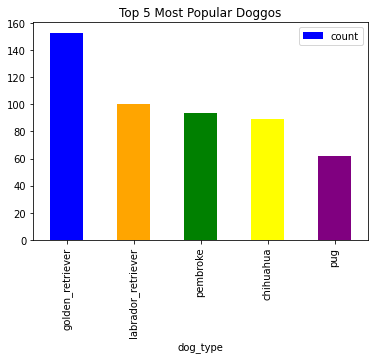

In [210]:
# plot results in bar graph
my_colors=['blue','orange', 'green', 'yellow', 'purple']
df2.plot(kind='bar', x='dog_type', y='count', color=my_colors, title='Top 5 Most Popular Doggos');

In [211]:
# golden retriever percent
df2['count'][0]/df2['count'].sum()

0.3072289156626506

In [212]:
# all retriever probabilty
(df2['count'][0] + df2['count'][1])/df2['count'].sum()

0.5080321285140562

**Are Puppers the best rated Dogs?**

According to [DoggoLingo](https://en.wikipedia.org/wiki/DoggoLingo#:~:text=An%20affectionate%20way%20of%20saying,woofer%2C%20floofer%20or%20boofer) a doggo is an affectionate term for any dog. Since my analysis includes all dogs, I will not include the 'doggo' column but keep it focused to 'puppo', 'pupper', and 'floofer':

pupper - puppy

floofer - very big dog

puppo - very small dog

I will analyze to see if puppers are the highest rated doggo.

**NOTE:** there seems to be two different definitions on what a 'puppo' is. I am going to use the FIRST definition in [Urban Dictionary](https://www.urbandictionary.com/define.php?term=Puppo) meaning of a small dog(puppo) and puppy(pupper) for one analysis and then take 'puppo'+'pupper'/2 for another analysis using the second definition in Urban Dictionary.

**ALSO NOT:** not all tweets indicated the type of dog, doggo just defines dog. I am more interested in the subsets of doggos.



In [213]:
# get 'doggo' 'floofer', 'pupper', 'puppo', 'favorited'
dog_fav_4=main[['tweet_id', 'doggo', 'floofer', 'pupper', 'puppo', 'rating', 'favorite_count']]
dog_fav_4

,tweet_id,doggo,floofer,pupper,puppo,rating,favorite_count
0,892420643555336193,NaN,NaN,NaN,NaN,1.3,33612
1,892177421306343426,NaN,NaN,NaN,NaN,1.3,29148
2,891815181378084864,NaN,NaN,NaN,NaN,1.2,21936
3,891689557279858688,NaN,NaN,NaN,NaN,1.3,36665
4,891327558926688256,NaN,NaN,NaN,NaN,1.2,35063
...,...,...,...,...,...,...,...
1941,666049248165822465,NaN,NaN,NaN,NaN,0.5,88
1942,666044226329800704,NaN,NaN,NaN,NaN,0.6,245
1943,666033412701032449,NaN,NaN,NaN,NaN,0.9,100
1944,666029285002620928,NaN,NaN,NaN,NaN,0.7,112


### dog lingo

**Tidy up the doggo dataframe**

Define Requirement:

Replace doggo, floofer, pupper, and puppo columns with single column and value via melt 


Code 

In [214]:
# create another column where we combine the dog lingo
dog_fav_4= pd.melt(dog_fav_4,id_vars = ['rating', 'favorite_count','tweet_id'] ,value_name='dog_lingo',value_vars = ['doggo', 'floofer', 'pupper', 'puppo'])

In [215]:
# drop the column named variable
dog_fav_4= dog_fav_4.drop(labels='variable', axis=1)

In [239]:
dog_fav_4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 312 entries, 9 to 6634
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   rating          312 non-null    float64
 1   favorite_count  312 non-null    int64  
 2   tweet_id        312 non-null    int64  
 3   dog_lingo       312 non-null    object 
dtypes: float64(1), int64(2), object(1)
memory usage: 12.2+ KB


In [216]:
# keep all dog_lingo values not null
dog_fav_4 = dog_fav_4[dog_fav_4['dog_lingo'].notnull()]

**Test**

In [217]:
# view data frame
dog_fav_4.sample(10)

,rating,favorite_count,tweet_id,dog_lingo
5091,1.1,2484,688916208532455424,pupper
145,1.3,41721,855851453814013952,doggo
6156,1.3,5000,819952236453363712,puppo
5249,1.0,2847,679777920601223168,pupper
4241,1.1,7215,814986499976527872,pupper
4708,0.9,2866,735137028879360001,pupper
248,1.2,16678,832032802820481025,doggo
6128,1.4,53703,825535076884762624,puppo
5322,1.3,2608,676617503762681856,pupper
5393,1.0,578,674737130913071104,pupper


In [218]:
dog_fav_4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 312 entries, 9 to 6634
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   rating          312 non-null    float64
 1   favorite_count  312 non-null    int64  
 2   tweet_id        312 non-null    int64  
 3   dog_lingo       312 non-null    object 
dtypes: float64(1), int64(2), object(1)
memory usage: 12.2+ KB


Pupper is the most common lingo for dogs

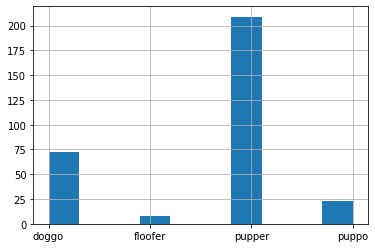

In [219]:
dog_fav_4['dog_lingo'].hist();

We still need to answer the question:

**Are Puppers the best rated Dogs?**

In [220]:
# checking for outliers for all dog ratings
mean=dog_fav_4['rating'].mean()
sd=dog_fav_4['rating'].std()
(mean, sd)

(1.1096153846153847, 0.1992845228529456)

In [221]:
# choose 4 standard deviations from the mean
# remove outliers that lie more than 4 std from the mean
dog_fav= dog_fav_4[(dog_fav_4['rating']<= mean+(4*sd))] 

In [222]:
dog_fav.describe()

,rating,favorite_count,tweet_id
count,311.000000,311.000000,3.110000e+02
mean,1.104502,10119.315113,7.462406e+17
std,0.177924,16422.443155,6.485696e+16
min,0.300000,578.000000,6.721600e+17
25%,1.000000,2305.000000,6.858056e+17
50%,1.100000,4956.000000,7.351370e+17
75%,1.200000,10739.500000,8.011151e+17
max,1.400000,143770.000000,8.902403e+17


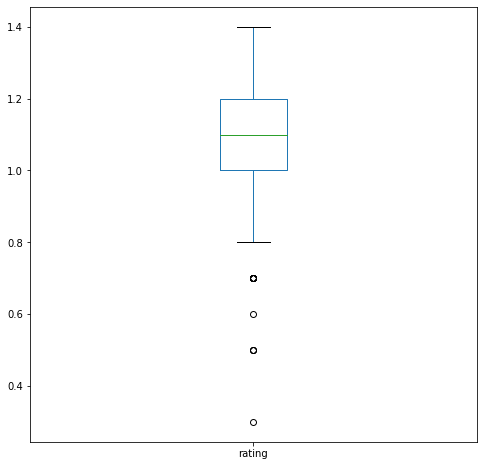

In [223]:
# view outliers again
dog_fav.boxplot(column=['rating'], grid=False, figsize=(8,8));

In [224]:
# create a dictionary of the means, not including doggo, whic is another term for dog, I am more interested in the subsets of doggos
mean_ratings= {'Floofer': [dog_fav.loc[dog_fav['dog_lingo']=='floofer', 'rating'].mean(), dog_fav.loc[dog_fav['dog_lingo']=='floofer', 'favorite_count'].mean()], 'Puppo': [dog_fav.loc[dog_fav['dog_lingo']=='puppo', 'rating'].mean(), dog_fav.loc[dog_fav['dog_lingo']=='puppo', 'favorite_count'].mean()], 'Pupper': [dog_fav.loc[dog_fav['dog_lingo']=='pupper', 'rating'].mean(), dog_fav.loc[dog_fav['dog_lingo']=='pupper', 'favorite_count'].mean()]}

In [225]:
mean_ratings

{'Floofer': [1.1875, 11602.0],
 'Puppo': [1.2043478260869567, 20419.478260869564],
 'Pupper': [1.0649038461538463, 6457.3317307692305]}

In [226]:
# create a datframe of the means and plot
doggo_rating_mean=pd.DataFrame(mean_ratings)
doggo_means=doggo_rating_mean.T
doggo_means.describe()

,0,1
count,3.000000,3.000000
mean,1.152251,12826.269997
std,0.076112,7061.126801
min,1.064904,6457.331731
25%,1.126202,9029.665865
50%,1.187500,11602.000000
75%,1.195924,16010.739130
max,1.204348,20419.478261


In [227]:
doggo_means.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3 entries, Floofer to Pupper
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       3 non-null      float64
 1   1       3 non-null      float64
dtypes: float64(2)
memory usage: 72.0+ bytes


In [228]:
# view df
doggo_means

,0,1
Floofer,1.187500,11602.000000
Puppo,1.204348,20419.478261
Pupper,1.064904,6457.331731


In [229]:
# Rename mean column to 'mean'
doggo_means.columns=['rate_mean', 'fav_mean']

In [230]:
# Display Dog Type Mean Dataframe
doggo_means.index

Index(['Floofer', 'Puppo', 'Pupper'], dtype='object')

Text(0.5, 1.0, 'Favorite Mean')

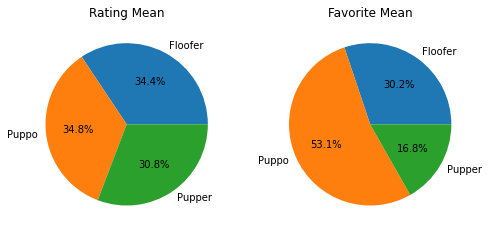

In [231]:
# plot pie charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,8))
value1= doggo_means['rate_mean']
value2=doggo_means['fav_mean']
ax1.pie(value1, labels=doggo_means.index, autopct = '%1.1f%%')
ax1.set_title('Rating Mean')
ax2.pie(value2, labels=doggo_means.index, autopct = '%1.1f%%')
ax2.set_title('Favorite Mean')


**Puppo** has the highest rating

**Puppo** dog type has the highest mean value, a bit higher than the average of all 3.

Combine 'puppo' and 'pupper', mean value, compare to floofer mean

In [232]:
# average of pupper and puppo
pp_mean=(doggo_means['rate_mean']['Puppo']+doggo_means['rate_mean']['Pupper'])/2
pp_mean

1.1346258361204016

In [233]:
# floofer mean
doggo_means['rate_mean'][0]

1.1875

**Floofer** has a higher rating when puppo and pupper types are averaged together.

In [234]:
doggo_rating_mean.insert(3, "puppo|pupper", pp_mean, True)
doggo_rating_mean[['Floofer', 'puppo|pupper']]

,Floofer,puppo|pupper
0,1.1875,1.134626
1,11602.0000,1.134626


Are iphones the most popular source?

Recall:

**SOURCE**

1 - tweetdeck

2 - vine.co

3 - twitter.com

4 - iphone

In [235]:
# get subset of main
# notice that #2 for vine.co was removed in the cleaning process
sources=main.source.value_counts()
sources=sources.to_frame()
sources=sources.rename(index={4:'iphone', 3:'twitter.com', 1:'tweetdeck'})

In [236]:
sources

,source
iphone,1908
twitter.com,28
tweetdeck,10


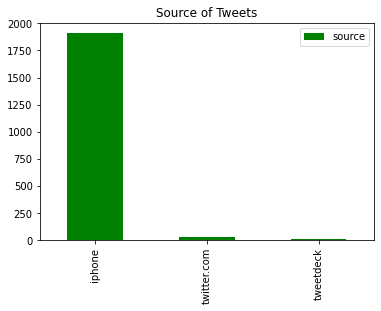

In [237]:
# plot results in bar graph
my_colors=['green', 'orange', 'purple']
sources.plot(kind='bar', color=my_colors, title='Source of Tweets');

In [238]:
sources['source'][0]/sources['source'].sum()

0.9804727646454265

<h2><span style="color:orange"><em>Conclusion</em></span></h2>

My assumptions starting this project:

- Retrievers are the most popular dog breed
- Puppers best the best rated dogs
- iphones are the most use source

**Are retrievers the most popular dog breed?** 

I came into this assumption with clear bias, as my childhood dog was Golden Retriever, "Lady", and she was an AMAZING dog. But, I was happy to find out, according to this dataset, retrievers are indeed the most popular doggos. In fac Golden Retriever came in with 169 and labrador retriever at 106 taking the two top spots. The next 3 followed with pembrok at 95,	chihuahua at 92, and pug at 65. Looking at probailities, there's a 32% chance that a WeRateDog Twitter user will post Golden Retriever image and a 52% chance they will post either Golden Retriever or Labrador Retriever image.

Out of curiosity, I wanted to see the ranking of most popular dogs in the U.S. and found an [article of the most searched dogs list](https://www.usatoday.com/story/news/nation/2022/09/26/bulldogs-most-searched-dog-breeds-us/8073052001/). Bull Dogs came in first, then German Shepard, Pit Bull and Labrador Retrivers in fourth place.

**Are Puppers the best rated dog type?**

When I began my analysis, I assumed, from a quick search, that 'puppers' were puppies, 'puppos' were small dogs and 'floofers' large dogs, with 'doggos' being any dog. I started off my analysis with this assumption and my first analysis shows that 'puppos' had the highest average rating of the three, 'floofers', 'puppers' and 'puppos'. But after talking to some longtime dog owners, it came to my attention that 'puppos' are considered puppies too. So, I decided to average the puppo and pupper ratings. With the combined effort, as it turns out, floofers come ahead when puppo and puppers are combined. 

I ended up throwing out a lot of data due to the fact that many Twitter users did not label their dog as floofer, puppo, pupper or even doggo. I dropped outliers that were 4 standard deviations from the mean. In the end, these labels seemed very subjective to me and would either need a closer look with more data and understanding of the labels.

**Are iphones the most used source?**

This answer is a resounding yes, iphones are clearly the most used source to post dog images with WeRateDogs, with a 98% chance.

iphone is the clear choice for WeRateDog users to post thier dog pictures.


**Issues I came Acroos**

- I relabeled the source column values before merging the data together. Not user if I will approach it that way again, as I ended up have a break in the numbering system I started with.

- Pupper and puppo debate was not something I expected. There's a lot of subjective reasoning around labling dogs and it made it hard to feel good about my outcome. Also, a lot of folks did not label the dogs. I ended up dropping a lot of data for this analysis which, I think reduced the statistical power of the dog type study.
